# Sensitivity Analysis build script

In [8]:
import os, sys

os.chdir('e:\Downloads (E)\@Books\@TPM\@PDPC\@data_analysis\model_build')
sys.path.append('e:\Downloads (E)\@Books\@TPM\@PDPC\@data_analysis\model_build')
# ^ just a sanity thing: console starts from project root, but pycharm 'run in console' runs with 'model_build' as working directory

import OFM_model as ofm
import OFM_sensitivity as ofms
import pandas as pd
import numpy as np
import math
from tqdm import tqdm  # for progress bars
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
# from matplotlib.colors import TwoSlopeNorm
# import cmasher as cmr
import colorcet as cet
from importlib import reload  ## for reloading packages
import OFM_postprocess_scripts as post
import OFM_sensitivity_postprocess as post_sa
import scipy
import pickle
import SALib as salib
import copy

In [9]:
# Instantiate constants
imports_df = pd.read_pickle("data_input/infectious_func_rw_rev3.pickletable")
ref_day = imports_df.loc[imports_df['date'] == '2021-11-26', :].index[
    0]  # reacquire reference day from imports function
model_vers = 'v6c'
# check and create directory
save_dir = f'output_figures/{model_vers}'
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
pop_NL = int(17.48e6)  # 17.48 million, constant

## Generate infectivity function
# gamma function shape params from An der Heiden and Buchholz
a = 2.14
rate = .59
x = range(0, 14, 1)
# generate discrete infectious function from gamma function
func_serial = scipy.stats.gamma.pdf(x=x, a=a, scale=1 / rate, loc=-1)
func_serial_cdf = scipy.stats.gamma.cdf(x=x, a=a, scale=1 / rate, loc=-1)  # for illustration and checking

# Clear out unused variables for cleaner variable inspection
# del available_distributions, a, rate, x

In [10]:
# plot other distributions
available_distributions = {
    'wild': (2.02, 0.42),
    'alpha': (2.0, 0.44),  #*
    'delta': (2.11, 0.50),  #*
    'omicron': (2.14, 0.59),  # *
    'omi_high1': (2.29, 0.6676),
    'omi_high2': (2.44, 0.7453),
    'omi_high3': (2.59, 0.8229)
    # 'omi_low1': (1.99, 0.5124),
    # 'omi_low2': (1.84, 0.4347),
    # 'omi_high1_mean':(2.44,0.6727),
    # 'omi_low1_mean':(1.84,0.5073)
}  #* fitted gamma function parameters from An der Heiden and Buchholz 2022

# create alternative infection functions for SA
func_serial_variable_pdf = tuple(
    (name, scipy.stats.gamma.pdf(x=x, a=params[0], scale=1 / params[1], loc=-1)) for name, params in
    available_distributions.items())
func_serial_variable_cdf = tuple(
    scipy.stats.gamma.cdf(x=x, a=ax, scale=1 / rx, loc=-1) for ax, rx in available_distributions.values())

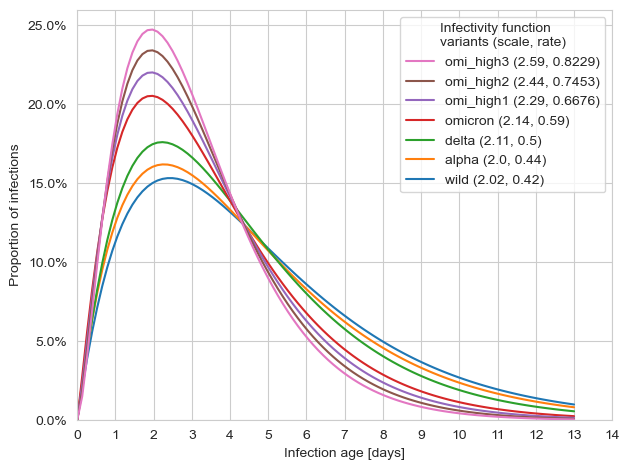

In [11]:

# Plot different distributions for visual comparison, uncomment to run the plotting
# REQUIRES available_distributions from previous cell
test_x = np.linspace(0, 13, 100)
test_savedict = {}
# test_palettes =

for variant, params in available_distributions.items():
    test_a, test_rate = params
    test_func_pdf = scipy.stats.gamma.pdf(x=test_x, a=test_a,
                                          scale=1 / test_rate, loc=0)
    test_func_cdf = scipy.stats.gamma.cdf(x=test_x, a=test_a,
                                          scale=1 / test_rate, loc=0)
    test_savedict[variant] = {'pdf': test_func_pdf, 'cdf': test_func_cdf}
    p = plt.plot(test_x, test_func_pdf, label=f'{variant} {str(params)}')

    # plt.axvline(, )
h, l = plt.gca().get_legend_handles_labels()
# test_order = [1,2,0,3,4]
# h = [h[i] for i in test_order]
# l = [l[i] for i in test_order]
# plt.legend(handles=h, labels=l, title='Infectivity function\nvariants (scale, rate)')

plt.legend(handles=reversed(h), labels=reversed(l), title='Infectivity function\nvariants (scale, rate)')
# plt.set_cmap('Set2')

# plt.axvline(x=14, c='tab:pink', alpha=1, zorder=0.8) # truncation point
# plt.axvline(x=(test_a-1)/test_rate, c='tab:cyan', alpha=1, zorder=0.1) # point of maximal mode
## Axis labelling
plt.xticks(range(0, 25, 1))
plt.xlabel('Infection age [days]')
plt.ylabel('Proportion of infections')
# set y-axis formatter to be percentages
plt.gca().yaxis.set_major_formatter(
    lambda y, _: f'{round(y * 100, 1)}%')  # underscore for 2nd lambda (pos) arg since we don't need it.
plt.ylim(0., None)
plt.xlim(0., 14)
plt.tight_layout()
# plt.savefig(f'output_figures/{model_vers}/infectivity_pdf_plot_(Omicron).jpg', dpi=300)

In [12]:
p_range = list(range(-7, 31, 7)) + [500]  # days of flight bans relative to 26 Nov 2021
u_ImportsFlights = list(range(5, 66, 10))  # scaling imports function for X imports arriving on 26 Nov 2021
u_ImportsIndirect = list(np.arange(0, 31, 5) / 100)  # 0, 5, ...30% indirect
u_Rzero = list(np.arange(12, 21, 1) / 10)  # steps of 0.1
label_savedir = 'data_output'

# v2 SA arrangement
We run a set of SA experiments per flight ban (aka 'policy'). The varied parameters are:
- Direct import scaling ```u_ImportsFlights```
- Indirect import scaling ```u_ImportsIndirect```
- Initial Effective Reproduction Number ```u_Rzero```

This allows us to get the sensitivity of the varied parameters with later/earlier flight bans.

In [13]:
# Following code is for code development of sensitivity analysis, comment out if just running SA
reload(ofm)
reload(ofms)

<module 'OFM_sensitivity' from 'E:\\Downloads (E)\\@Books\\@TPM\\@PDPC\\@data_analysis\\model_build\\OFM_sensitivity.py'>

In [14]:
# Try given-data methods, adapted for this model?
# a full-factorial analysis is sufficient for the model
# for pday in p_range:  # iterate over policies
model_engine = 'step_v2b_variable_beta_constant_R'
sa_exp = ofms.ISIR_SensitivityExperiments(
    # Core Model params
    p_FlightBans=p_range,
    u_Rzero=u_Rzero,
    u_ImportsFlights=u_ImportsFlights,
    u_ImportsIndirect=u_ImportsIndirect,
    # Model constants
    u_ImportsFunc=imports_df['infect_presence'],
    c_SimTime=200,
    # maximal simulation time (ie. timeout), simulations would terminate when a steady state is reached
    c_import_scaling_mode=2,
    # 2: scaling for X imports ON 26 Nov 2021 (case study), 1: scaling for X total imports UP TO 26 Nov 2021
    c_model_engine=model_engine,  # Serial interval approach, with infection age affecting infectivity
    u_Func_Infectious=func_serial_variable_pdf,
    #(func_serial,),  # Serial interval approach, infectivity function per infection age
    s_indirect_import_mode=2,
    # 2: indirect imports treated as N% of total import flow, 1: indirect imports treated as N% of direct import flow
)

names_changed = False  # useful later for checking if the Problem 'names' object is changed


In [15]:
sa_exp.sample_ff()
print(f'Total experiments: {sa_exp.problem.samples.shape[0]} for {sa_exp.problem.samples.shape[1]} outputs')

Total experiments: 21609 for 5 outputs


In [16]:
# execute SA simulations
sa_exp.ISIR_evaluate_mp(n_workers=7)
# and save to pickle
with open(f'data_output/model{model_vers}_SAexp.pickleobject', 'wb') as save_file:
    pickle.dump(sa_exp, save_file)

OFM_PE: Running MULTIPROCESS mode with 21609 experiments


100%|██████████| 21609/21609 [09:05<00:00, 39.59it/s]


OFM_PE: all experiments completed at 9.1 mins


In [5]:
# Optional: read from pickle
sa_exp = post.read_experiments_from_pickle(f'data_output/model{model_vers}_SAexp.pickleobject')

In [18]:
# correction needed: need to get gained delay
sa_exp_rel = copy.copy(sa_exp)
sae_scenarios = pd.DataFrame.from_dict(sa_exp_rel.scenarios, orient='index')
sae_scenarios['p_FlightBans'] = sae_scenarios[
                                    'p_FlightBans'] - sa_exp_rel.c_nominal_ref_date  # get the flight bans in relative form
sae_scenarios['u_Func_Infectious'] = pd.DataFrame(sae_scenarios['u_Func_Infectious'].tolist())[0]
sae_nones = sae_scenarios[sae_scenarios['p_FlightBans'] == 500]



In [19]:
reload(post_sa)
col_labels_to_match = ['u_Func_Infectious', 'u_Rzero', 'u_ImportsFlights', 'u_ImportsIndirect']
# find indices where the scenario values match the nones category (with no flight ban
sae_nones_idxs = post_sa.multicol_match_get_index(sae_scenarios, sae_nones, col_labels_to_match=col_labels_to_match)
result_idx = 0
test_relgain = sa_exp_rel.problem.results[:, result_idx] - sa_exp_rel.problem.results[sae_nones_idxs, result_idx]


In [33]:
sa_exp_rel.problem.results.shape

(21609, 6)

In [43]:
sa_exp_rel.problem['outputs']=sa_exp.problem['outputs'].append('days_10k_cumulative_rel')
sa_exp_rel.problem.results = np.concatenate([sa_exp.problem.results, test_relgain.reshape((-1,1))], axis=1) # 'reshape' is just to convert the 1d vector into '2d'-ish for numpy operations to do, annoying.

In [44]:
# for pday, exp in sa_exp.items():
#     if n_outputs is None:
#         n_outputs = exp.problem['outputs']
#         sa_analysis = dict.fromkeys(n_outputs, {})

# section only for cumulative 10k outputs
# sa_output = sa_exp.problem['outputs'].index('days_10k_cumulative')  # note hardcode!
sa_methods = [  #('dmim', salib.analyze.delta),
    #('pawn', salib.analyze.pawn),
    ('hdmr', salib.analyze.hdmr), ]
sa_key_extract = {'hdmr': ['Sa', 'Sa_conf', 'Sb', 'Sb_conf', 'S', 'S_conf', 'ST', 'ST_conf',
                           'names']}  # extract specific values  from hdmr's rich output
# ^ because pandas' fromdict method cannot handle the diversity of datatypes
sa_preplot_rename = {
    'u_Rzero': 'R_E0',
    'p_FlightBans': 'Flight Ban Day',
    'u_ImportsIndirect': 'Proportion Indirect Flights',
    'u_ImportsFlights': 'Importation Scaling',
    'u_Func_Infectious': "Infection Function",
}
# sa_value_vars = {'hdmr': ['Sa','Sb','S','ST'],
#                  'dmim': ['delta', 'S1',],
#                  'pawn': ['minimum','mean','median','maximum']}

In [45]:
## Apply different SA analyses
sa_analysis = {}
# rename metric names in Problem object for plot readability
if not names_changed:
    sa_exp.problem['names'] = [sa_preplot_rename[name_ori] for name_ori in sa_exp.problem['names']]
    names_changed = True

for sa_label, sa_method in sa_methods:  # tqdm does live progress bar UI
    for sa_output_label in tqdm(sa_exp.problem['outputs']):
        idx = sa_exp.problem['outputs'].index(sa_output_label)
        sa_analysis[sa_output_label] = sa_method.analyze(problem=sa_exp.problem,
                                                         X=sa_exp.problem.samples,
                                                         Y=sa_exp.problem.results[:,
                                                           idx])  # these methods require that the results matrix is specifically pre-sectioned.
    # ^ Y: columns are outputs, rows are model runs
# print('\ndone')
del idx, sa_label, sa_method, sa_output_label

100%|██████████| 7/7 [00:28<00:00,  4.03s/it]


In [46]:
# Sort out relevant outputs and prepare dataset for plotting
sa_analysis2 = {}
for l, a in sa_analysis.items():
    a = dict((v, a[v]) for _, k in sa_key_extract.items() for v in k)
    sa_analysis2[l] = pd.DataFrame.from_dict(a, orient='columns').melt(id_vars='names')
## Cold storage, depreciated. Was from prior work with different analysis methods such as DMIM, but incompatible
# for l, a in sa_analysis.items():
#
#     if l in sa_key_extract.keys():
#         a = dict((k,a[k]) for k in sa_key_extract[l])  # get sectioned version of analysis dict
#     # Sanity check and correction for issue*
#     len_names = len(a['names'])  # hardcode: 'names' must be present!
#     len_values = int(scipy.stats.mode([len(item) for item in a.values()], keepdims=False).mode) # get the length of most other values
#     if len_names != len_values:
#         a['names'] = a['names'][:len_values]  # correct names entity to have the same length, dumb method
#
#     # create long-form pandas df for plotting
#     sa_analysis2[l] = pd.DataFrame.from_dict(a, orient='columns').melt(id_vars='names')
#
# # * Using different SA methods would lead to the overwriting of the 'names' attribute of the original Problem object (sa_exp.problem['names']. As HDMR also calculates per-input interaction, this increases the length of 'names' and causes errors for other metrics.

In [47]:
# Plotting for HDMR
re_label = r'$R_e$'
for plot_label, plot_data in sa_analysis2.items():

    # plot_fullname = 'Sensitivity Analysis\nHigh-Dimensional Model Representation'
    plot_data = plot_data.copy()
    # Could probably exclude S, because Sa, Sb and ST should already communicate sufficient information?
    plot_subcat = {True: 'CI (95%)', False: 'Value'}
    # plot_s2 = {True: 'Per-Parameter', False: 'Interaction'}
    # split the plot into 4: per-param interactions with CIs, and co-interactions & CIs
    # cleaner to do separate plots?
    # plot 1: solely params, ST and Sa
    # plot 2: all params and interactions, S, Sa, Sb
    # ? plot confidence bar on top?
    is_s2 = plot_data['names'].str.contains(
        '/')  # note hardcode assuming that all interactions has a / character within
    plot_data_s1 = plot_data[
        (~is_s2) & (plot_data['variable'].isin(['ST', 'ST_conf', 'S', 'S_conf', 'Sa', 'Sa_conf']))].copy()
    plot_data_s1['is_conf'] = plot_data_s1['variable'].str.contains('_conf').map(
        plot_subcat)  # find indices/rows that are for confidence bounds
    plot_data_s1['variable'] = plot_data_s1['variable'].str.replace(r'_conf',
                                                                    '')  # delete '_conf' string attachment if available)
    plot_data_s1 = plot_data_s1.pivot_table(index=['names', 'variable'], columns='is_conf',
                                            values='value').reset_index()
    # plot_data_s1.sort_values(by=['R_E0', 'Flight Ban Day', 'Importation Indirect Flights', 'Importation Scaling'], inplace=True)
    plot_data_s1['names'] = plot_data_s1['names'].str.replace(pat='R_E0', repl=re_label, regex=False)
    plot_data_s1['names'] = plot_data_s1['names'].str.replace(pat='Proportion Indirect Flights', repl='Leakage Rate',
                                                              regex=False)
    # Find plot order, from largest ST value and descending
    plot_s1_order = plot_data_s1[plot_data_s1.variable == 'ST'].sort_values(by='Value', ignore_index=True,
                                                                            ascending=False).names.to_list()
    plot_data_s1.rename(columns={'variable': 'Sensitivity\nIndex'},
                        inplace=True)  # rename DF column because it affects legend name
    # # set custom plot order (depreciated)
    # # plot_s1_test = plot_data_s1.copy().set_index(['names','variable'], drop=False)
    # # plot_s1_test = plot_s1_test.reindex(pd.MultiIndex.from_product([plot_s1_order, ["ST",'Sa']]))
    #
    # Section for interaction effects
    plot_data_s2 = plot_data[
        plot_data['variable'].isin(['S', 'S_conf'])].copy()  # $ ensures it is present at the end, thus excluding ST
    plot_data_s2['is_conf'] = plot_data_s2['variable'].str.contains('_conf').map(
        plot_subcat)  # find indices/rows that are for confidence bounds
    plot_data_s2['variable'] = plot_data_s2['variable'].str.replace(r'_conf',
                                                                    '')  # delete '_conf' string attachment if available)
    plot_data_s2 = plot_data_s2.pivot_table(index=['names', 'variable'], columns='is_conf',
                                            values='value').reset_index()
    # plot_data_s2.sort_values(by=['R_E0', 'Flight Ban Day', 'Importation Indirect Flights', 'Importation Scaling'], inplace=True)
    plot_data_s2['names'] = plot_data_s2['names'].str.replace(pat='R_E0', repl=re_label, regex=False)
    plot_data_s2['names'] = plot_data_s2['names'].str.replace(pat='Proportion Indirect Flights', repl='Leakage Rate',
                                                              regex=False)
    plot_data_s2['names'] = plot_data_s2['names'].str.replace(pat='/', repl=' + ', regex=False)
    plot_s2_order = plot_data_s2.sort_values(by='Value', ignore_index=True, ascending=False).names.to_list()
    plot_data_s2.rename(columns={'variable': 'Sensitivity\nIndex'},
                        inplace=True)  # rename DF column because it affects legend name

    # Find index of items with interaction
    plot_s2_interact_idx = [i for i, x in enumerate(plot_s2_order) if '+' in x]

    ## cell seperation point
    fig, ax = plt.subplots(nrows=2, figsize=(9, 9))
    plot_fullname = 'Sensitivity Indices using High-Dimensional\nModel Representation (HDMR) method'
    cmap = {'ST': 'tab:blue', 'Sa': 'tab:orange', 'S': 'tab:green'}
    per_plot = ["A: Total and Individual Contributions per Parameter",
                "B: Ranking of Individual and Interactive Contributions"]

    sns.barplot(data=plot_data_s1, order=plot_s1_order, x='names', y='Value', hue='Sensitivity\nIndex',
                hue_order=['ST', 'S', 'Sa'],
                ax=ax[0], palette=cmap)
    sns.barplot(data=plot_data_s2, order=plot_s2_order, x='names', y='Value', hue='Sensitivity\nIndex', ax=ax[1],
                palette=cmap)
    # plot errorbars
    for enum, dset in enumerate([plot_data_s1, plot_data_s2]):
        ax_curr = ax[enum]
        e_xcoords, e_ycoords = [p.get_x() + 0.5 * p.get_width() for p in ax_curr.patches], [p.get_height() for p in
                                                                                            ax_curr.patches]
        # TODO: hacky fix
        e_xcoords = e_xcoords[:dset.shape[0]]
        e_ycoords = e_ycoords[:dset.shape[0]]
        e_size = dset.sort_values(['Sensitivity\nIndex', 'names'])['CI (95%)']
        ax_curr.errorbar(x=e_xcoords, y=e_ycoords, yerr=e_size,
                         fmt='none', elinewidth=2, c='k')
        for c in ax_curr.containers[:-1]:
            ax_curr.bar_label(c, fontsize=10, padding=15, fmt='%.3f')

        ax_curr.set_title(per_plot[enum], fontweight='bold')
        plt.sca(ax_curr)
        plt.ylabel('')
        plt.xlabel('')
    plt.xticks(rotation=35, ha='right')
    # plt.suptitle(plot_fullname, fontsize=14)
    for idx in plot_s2_interact_idx:
        ax[1].get_xticklabels()[idx].set_weight('bold')

    plt.tight_layout(rect=(0, 0, 1, 1), h_pad=1)
    plt.savefig(f'output_figures/{model_vers}/SA-{sa_exp.problem.results.shape[0]}_{plot_label}_plot_hdmr.jpg', dpi=300)
    plt.clf()


<Figure size 900x900 with 0 Axes>

<Figure size 900x900 with 0 Axes>

<Figure size 900x900 with 0 Axes>

<Figure size 900x900 with 0 Axes>

<Figure size 900x900 with 0 Axes>

<Figure size 900x900 with 0 Axes>

<Figure size 900x900 with 0 Axes>

In [242]:
# checking some stuff
plot_data_s2['Value'].sum()

0.9107927731038948

In [11]:
# Normal extraction for plot
sa_analysis2 = {}

for metric, subdict in sa_analysis.items():
    sa_analysis2[metric] = pd.DataFrame.from_dict(subdict, orient='columns').assign(metric=metric)
#
# sa_analysis22 = pd.concat(sa_analysis2, ignore_index=True)
#         #pd.concat([pd.DataFrame.from_dict(v, orient='columns') for k, v in subdict.items()], ignore_index=True)  #.melt(id_vars=['names', 'pday'], value_vars=['delta', 'S1'])
# value_vars_dmim = ['delta', 'S1']
# value_vars_pawn = []
# sa_analysis22 = sa_analysis22.melt(id_vars=['metric','names'],
#                                    value_vars=)


ValueError: All arrays must be of the same length

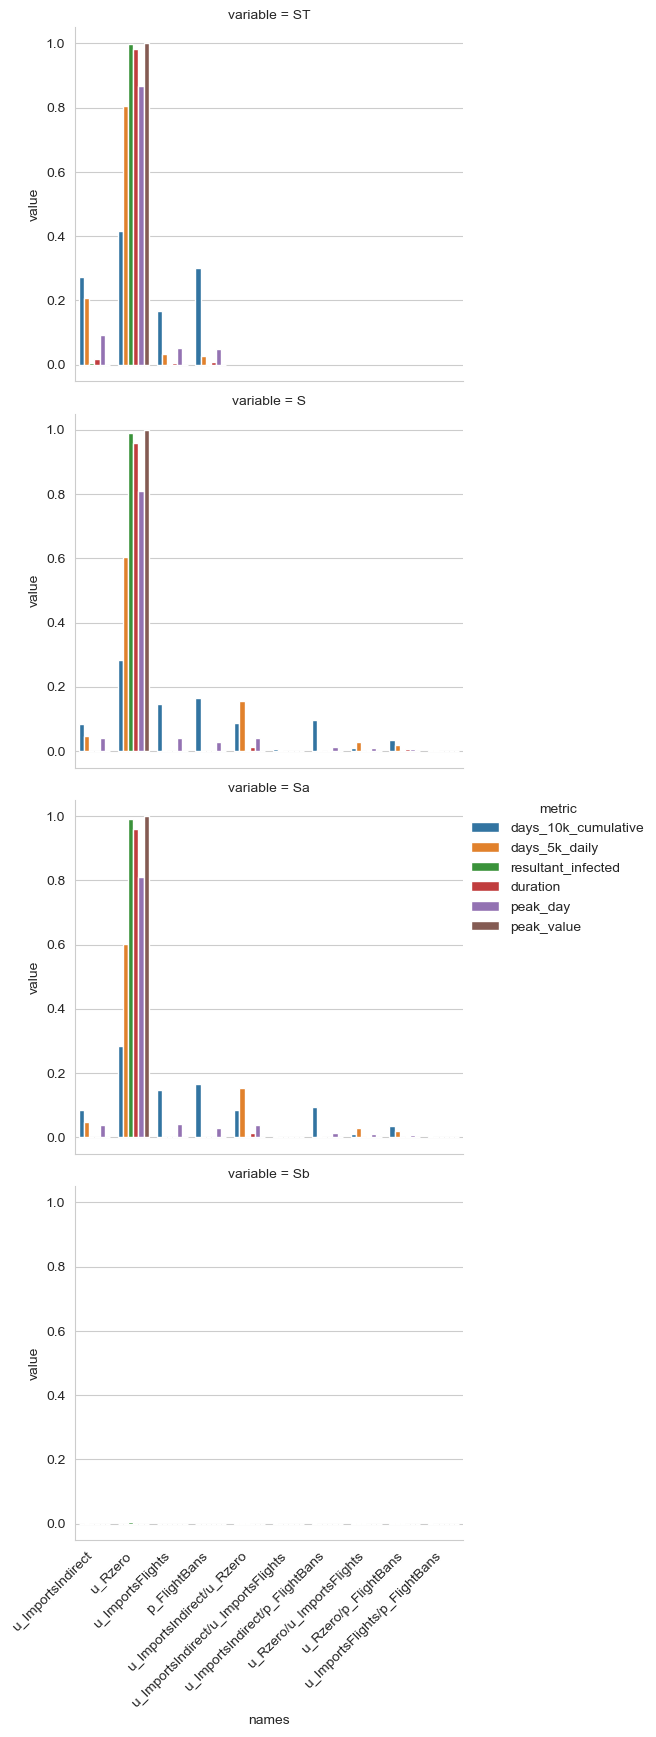

In [20]:
# fig,ax = plt.subplots(nrows=2)
sns.catplot(sa_analysis22,
            y='value', x='names', row='variable', hue='metric',
            kind='bar', height=4, aspect=1.2)
# for idx, x in enumerate(['delta', 'S1']):
#     sns.barplot(data=sa_analysis22,
#                 y=x, x='names', hue='metric', ax=ax[idx])
name_addon = "HDMR"
plt.xticks(rotation=45, ha='right')
plt.savefig(f'output_figures/v5.2/SA{model_vers}_analysis-testplot_{name_addon}.jpg', dpi=300)

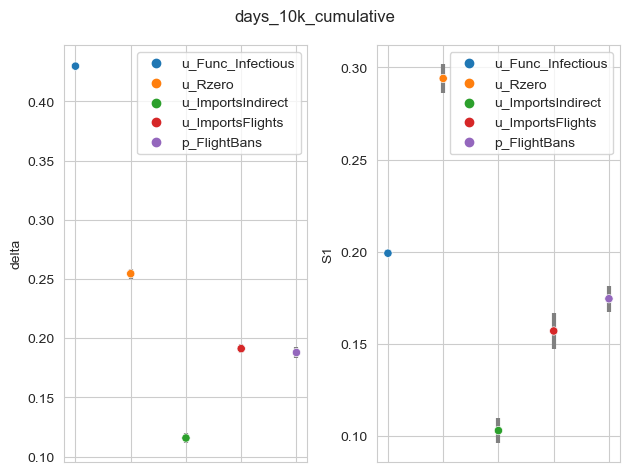

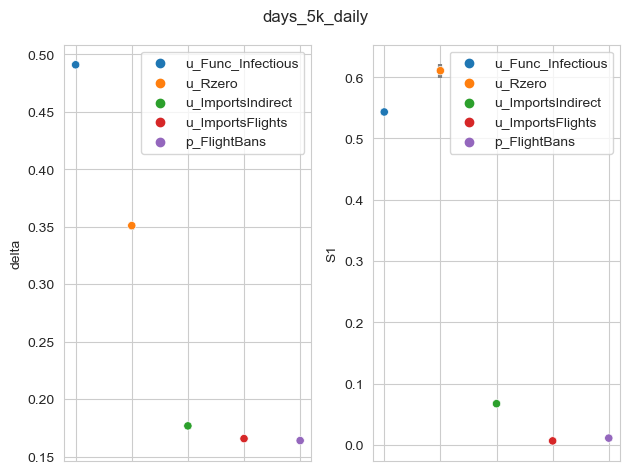

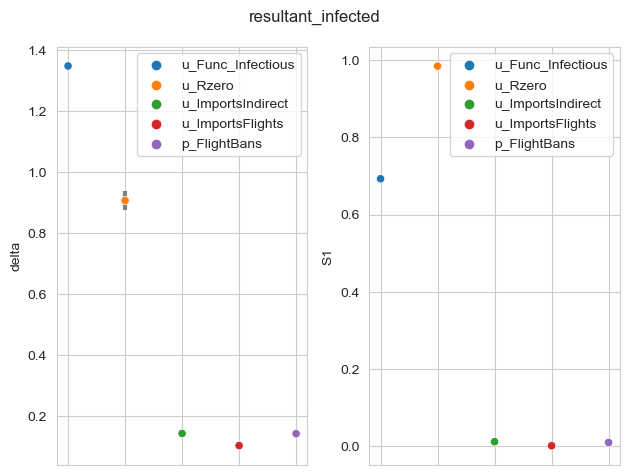

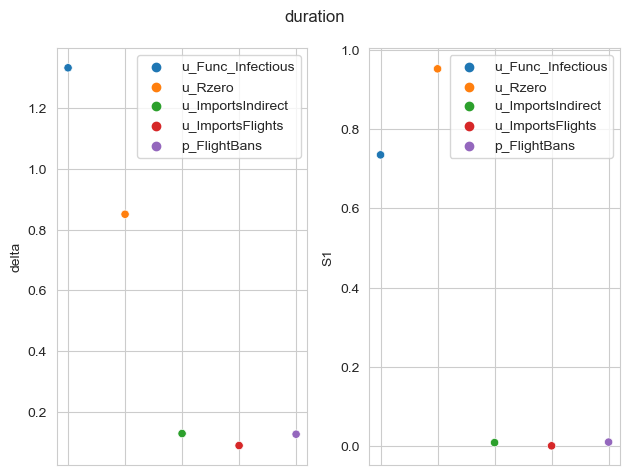

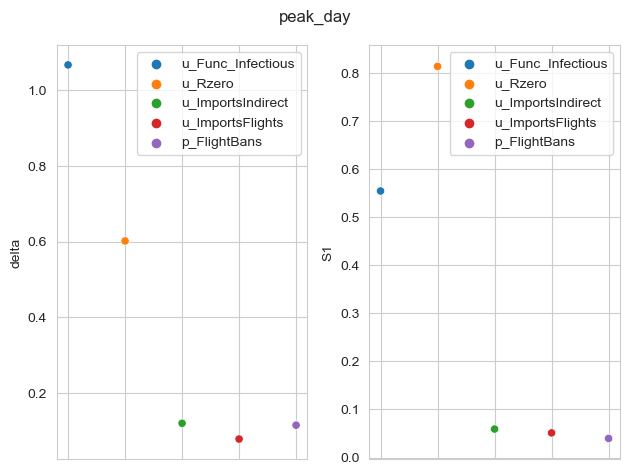

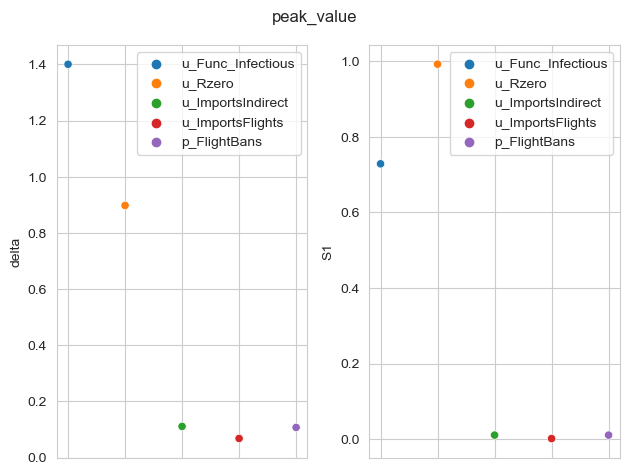

In [55]:
# depreciated
# plot_data = sa_analysis2['d
# ays_10k_cumulative']
cmap = 'tab10'
for metric, results in sa_analysis.items():
    fig, ax = plt.subplots(ncols=2)

    for idx, x in enumerate(['delta', 'S1']):
        # conf = [(bound, bound) for bound in results[f'{x}_conf']]

        sns.scatterplot(x=results['names'], y=results[x], hue=results['names'], ax=ax[idx], palette=cmap)
        # ax[idx].errorbar(x=results['names'], y=results[x], yerr=results[f'{x}_conf'],
        #                  fmt='none', elinewidth=3, c='gray', zorder=0.8)
        ax[idx].xaxis.set_ticklabels([])
        ax[idx].set_ylabel(x)
        # sns.lineplot(x=results['names'], y=results['S1'], hue=results['names'], ax=ax[1])
    fig.suptitle(metric)
    plt.tight_layout()
    plt.show()
    fig.savefig(f'output_figures/{model_vers}/SA-{metric}-test.jpg', dpi=300)
    # break


In [54]:
# try with only sampling rate of 1
exp.run_experiments_multiprocess(n_workers=4, postprocess_ops=exp.setup_postprocessing())




# Cold storage for Sobol'-based SA

In [47]:
# SA parameters and model variables
p_range = range(-7, 8, 1)  # days of flight bans relative to 26 Nov 2021
u_ImportsFlights = list(range(5, 31, 5))  # TODO: note modified bounds
u_ImportsIndirect = list(np.arange(0, 31, 5) / 100)
u_Rzero = list(np.arange(13, 22, 2) / 10)
sa_method = 'sobol'  # FAST could be an alternative, but compatibility is not confirmed.
include_2ndorder = True  # calculate 2nd-order indices, only works with Sobol

# Calculate expected simulation cost, per policy set
sample_rate = 2  # how many times a sample set should be sampled within the full-factorial combinations
params_varied = [u_ImportsIndirect, u_ImportsFlights, u_Rzero]
n_combis = math.prod(len(u) for u in params_varied)  # get full-factorial combinations per p_set
_dfactor = 2 if include_2ndorder else 1  # factor in number of Sobol samples
# solve for minimum sobol sampling size (N) for ample coverage of discrete space,
n_sa_samples = 2 ** math.ceil(
    math.log((n_combis * sample_rate) / (_dfactor * len(params_varied) + 2), 2))
cost_per_set = n_combis * (_dfactor * len(params_varied) + 2)  # expected number of experiments per policy set
cost_total = cost_per_set * len(p_range)  # total number of experiments incl. all policy sets

# Print out expected simulation costs and intermediate derivations
print(f'Full-factorial combinations of inputs per PSet: {n_combis}\n'
      f'Minimal Sobol\' sample size (N) for sample rate {sample_rate}: {n_sa_samples}\n'
      f'SA cost for Sobol\' method per PSet: {cost_per_set}\n'
      f'Total SA cost for {len(p_range)} PSets: {cost_total}\n')
# note 'PSet' = policy set = 1 flight ban choice + all other model input combinations

del _dfactor

Full-factorial combinations of inputs per PSet: 210
Minimal Sobol' sample size (N) for sample rate 2: 64
SA cost for Sobol' method per PSet: 1680
Total SA cost for 15 PSets: 25200



In [36]:
# Create SA experiments per policy set
label_savedir = 'data_output'
sa_exp = {}  # SA experiments save target
sa_exps_names = {}
for pday in p_range:  # iterate over policies
    exp = ofms.ISIR_SensitivityExperiments(
        # SA-specific arguments
        n_samples=n_sa_samples,
        sa_method=sa_method,
        sampler_args={'calc_second_order': include_2ndorder},  # include 2nd-order calculation, extra cost
        # Core Model params
        p_FlightBans=(pday,),
        u_Rzero=u_Rzero,
        u_ImportsFlights=u_ImportsFlights,
        u_ImportsIndirect=u_ImportsIndirect,
        # Model constants
        u_ImportsFunc=imports_df['infect_presence'],
        c_SimTime=200,
        # maximal simulation time (ie. timeout), simulations would terminate when a steady state is reached
        c_import_scaling_mode=2,
        # 2: scaling for X imports ON 26 Nov 2021 (case study), 1: scaling for X total imports UP TO 26 Nov 2021
        c_model_engine='step_v2_variable_beta',  # Serial interval approach, with infection age affecting infectivity
        u_Func_Infectious=(func_serial,),  # Serial interval approach, infectivity function per infection age
        s_indirect_import_mode=2,
        # 2: indirect imports treated as N% of total import flow, 1: indirect imports treated as N% of direct import flow
        debug_mode=False,
    )

    sa_exp[pday] = exp
    sa_exps_names[pday] = f'SA_m{model_vers}_n{n_sa_samples}_p{pday}'  # label

# v1 SA arrangemt (likely depreciated)
First functional script for an SA, but the number of samples was insufficient for the expected sample space, and such an all-in analysis may miss the nonlinear nature of varying flight bans (which become significantly less effective when applied later). Thus, the v2 arrangement explicitly breaks out the SA per flight ban day, hopefully allowing a clearer observation of other model input impacts over time.

In [14]:
## Initialise sensitivity analysis experiment object

# (if working on experiment backend, run following instead of restarting entire script)
# reload(ofm)  # reload this first because ofms is dependent on this
# reload(ofms)

N = 2 ** 9  # 2**12 = 4096
adden = 'test'
label_sensexp = f"SA_N{N}_{model_vers}_{adden}"
label_sensexp_savepath = f'data_output/model{model_vers}_{label_sensexp}.pickleobject'
sens_exp = ofms.ISIR_SensitivityExperiments(
    sa_method='sobol',  # could consider FAST or Sobol
    n_samples=N,
    u_ImportsFunc=imports_df['infect_presence'],
    p_FlightBans=tuple(range(-7, 31, 1)),  # TODO: note modified bounds
    u_ImportsIndirect=list(np.arange(0, 31, 5) / 100),
    u_Rzero=list(np.arange(12, 21, 1) / 10),
    u_ImportsFlights=list(range(7, 21, 1)),  # TODO: note modified bounds
    u_Func_Infectious=(func_serial,),
    c_SimTime=200,
    c_import_scaling_mode=2,  # **
    c_model_engine='step_v2_variable_beta',
    s_indirect_import_mode=2,
    debug_mode=False,
    sampler_args={'calc_second_order': True},
)
n_params = len(sens_exp.params_varied)
print(f"Total Experiments (Sobol' method): {N} samples x (2 x {n_params} variables + 2) = {N * (2 * n_params + 2)}")

Total Experiments (Sobol' method): 512 samples x (2 x 4 variables + 2) = 5120


In [0]:
# Execute sensitivity experiments in multiprocessing environment
sens_exp.ISIR_evaluate_mp(n_workers=7)
# Calculate sensitivity indices for defined SA problem
sens_exp.ISIR_analyse(calc_second_order=True)
# save entire SA Experiments object (incl. SA analysis) for later use
with open(label_sensexp_savepath, 'wb') as save_file:
    pickle.dump(sens_exp, save_file)
print(f'saved experiment outputs')

In [26]:
# Reading saved SA experiments (mutually exclusive with previous cell)
# sens_exp = post.read_experiments_from_pickle(label_sensexp_savepath)

In [7]:
# Get SALib analysis as pandas dataframe
# _sens_analysis = pd.DataFrame.from_dict(sens_exp.problem.analysis)
label_sens_analysis = f'data_output/{label_sensexp}.pickletable'
_sens_analysis = pd.read_pickle(label_sens_analysis)
names_map = {  # mapping function for renaming labels to more readable forms
    "u_ImportsIndirect": 'Indirect imports',
    'u_Rzero': 'Initial Re',
    'p_FlightBans': 'Flight ban day',
    'u_ImportsFlights': 'Direct imports',
    'days_10k_cumulative': 'Days until 10,000 cumulative local cases',
    'days_5k_daily': 'Days until 5,000 new daily local cases',
    'resultant_infected': "Proportion of population infected at end of epidemic",
    'duration': 'Duration of epidemic (>1000 new daily local cases)',
    'peak_day': 'Day of simulated epidemic peak',
    'peak_value': "Number of new local incidences at simulated epidemic peak"
}

In [8]:
# save analysis to file
# _sens_analysis.to_pickle(label_sens_analysis)

In [11]:
## Extract indices and rearrange them for plotting
# problem with disjoint naming -> possibility that names may be lost across save/load
sens_analysis = {}

# extract per output metric
for col in _sens_analysis.columns:  # columns are output names
    _names = [names_map[n] for n in
              sens_exp.problem['names']]  # rename shortform factor names to readable forms, makes plotting easier

    # get ST and S1 indices with confidence bounds
    __sts1 = _sens_analysis.loc[['ST', 'ST_conf', 'S1', 'S1_conf'], col]
    # expand values from numpy array form into columns
    _sts1 = pd.DataFrame.from_records(__sts1, index=__sts1.index, columns=_names).sort_values(by='ST', axis=1,
                                                                                              ascending=False)
    #^ we sort the indices in descending strength (based on ST values)
    _sts1['Total'] = _sts1.sum(axis=1)
    _sts1.loc[['ST_conf', 'S1_conf'], 'Total'] = np.nan

    # get s2 indices and their confidence bounds. They are created as separate dataframes because they are 2D
    _s2 = pd.DataFrame(_sens_analysis.loc['S2', col], index=_names, columns=_names)
    _s2_conf = pd.DataFrame(_sens_analysis.loc['S2_conf', col], index=_names, columns=_names)
    # _s2alt = _s2.melt(ignore_index=False).dropna().sort_values(by='value', ascending=False)  # for showing as duplet of factors, not used

    # save per output metric
    sens_analysis[col] = {'STS1': _sts1.T, 'S2': _s2, 'S2_conf': _s2_conf}
    break



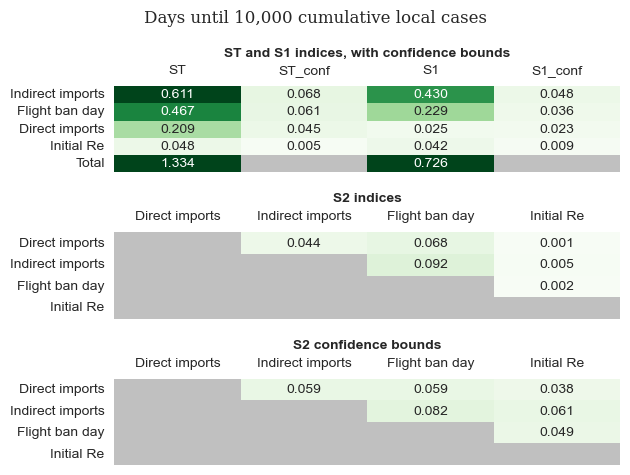

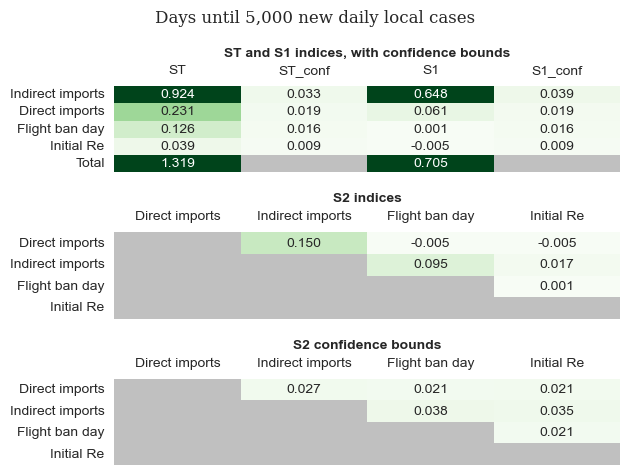

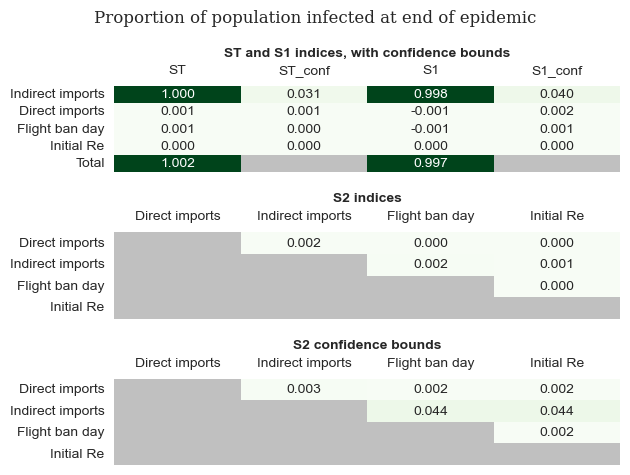

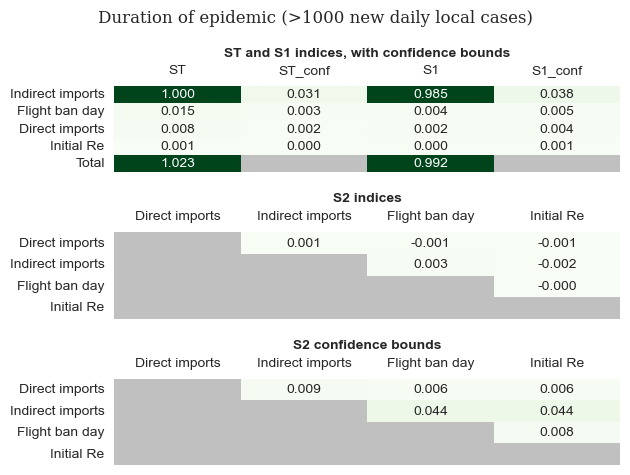

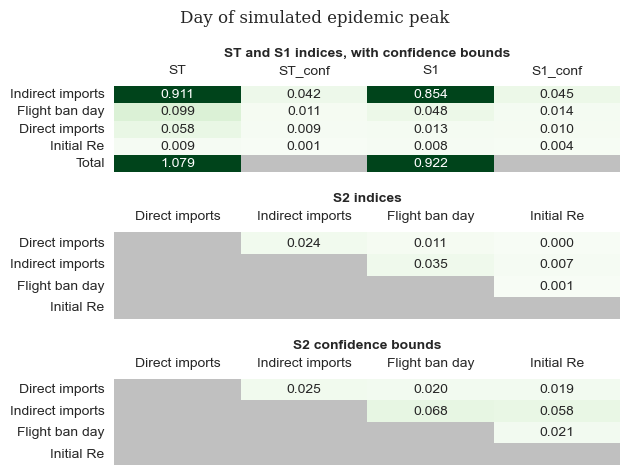

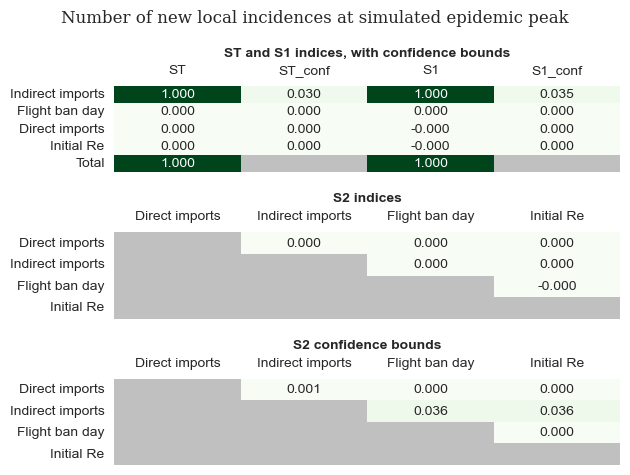

In [10]:
## Create heatmap plots per output metric
cmap = 'Greens'  # common colormap
subtitles = {'STS1': 'ST and S1 indices, with confidence bounds',
             'S2': 'S2 indices',
             'S2_conf': 'S2 confidence bounds'}
for col, ana in sens_analysis.items():
    fig, axes = plt.subplots(nrows=3)
    # plot for STS1, S2 and S2-confidence bounds
    for pos, dset in enumerate(ana.keys()):
        p = sns.heatmap(ana[dset], annot=True, fmt='.3f', ax=axes[pos], cmap=cmap, cbar=False, vmin=0., vmax=.6)
        #^ annot: numbers in cell
        p.set_facecolor('silver')  # for blank colour
        axes[pos].set_title(subtitles[dset], fontsize=10, fontweight='bold')
        axes[pos].xaxis.tick_top()  # place x-axis labels on top
        axes[pos].tick_params(axis='x', which='both', bottom=False, top=False)  # turn off plot ticks

    fig.suptitle(names_map[col], family='serif')

    plt.tight_layout()  # rearrange elements for better fit
    plt.subplots_adjust(hspace=0.7)  # enlarge space between subplots
    plt.savefig(f'output_figures/{model_vers}/{label_sensexp}_{col}.jpg', dpi=300)  # save single plot to file


# Depreciated Cold Storage

In [12]:
post_ops = sens_exp.setup_postprocessing()
# run singular experiments
# idx, output, output_post = sens_exp.handle_single_run(idx=None, variables=sens_exp.scenarios[0],
#                            constants=sens_exp.params_const,
#                            post_ops=post_ops)

# move on to multiprocessing
sens_exp.run_experiments_multiprocess(n_workers=6, postprocess_ops=post_ops)

OFM_PE: Running MULTIPROCESS mode with 10240 experiments


100%|██████████| 10240/10240 [05:23<00:00, 31.70it/s]


OFM_PE: all experiments completed at 5.39 mins


True

In [13]:
a1 = pd.DataFrame.from_dict(dict(sens_exp.experiments), orient='index')
a2 = a1.to_numpy()
sens_exp.problem['outputs'] = a1.columns.tolist()
sens_exp.problem.set_results(a2)
sens_exp.problem.analyze(sens_exp._analyser)

{'names': ['p_FlightBans', 'u_ImportsIndirect', 'u_ImportsFlights', 'u_Rzero'],
 'num_vars': 4,
 'bounds': array([[ 0, 33],
        [ 0,  7],
        [ 0, 11],
        [ 0,  9]]),
 'groups': None,
 'outputs': ['days_10k_cumulative',
  'days_5k_daily',
  'resultant_infected',
  'duration',
  'peak_day',
  'peak_value'],
 'dists': None,
 'sample_scaled': True}

In [14]:
print(sens_exp.problem)

Samples:
	4 parameters: ['p_FlightBans', 'u_ImportsIndirect', 'u_ImportsFlights', 'u_Rzero']
	10240 evaluations 

Outputs:
	6 outputs: ['days_10k_cumulative', 'days_5k_daily', 'resultant_infected', 'duration', 'peak_day', 'peak_value']
	10240 evaluations 

Analysis:
days_10k_cumulative:
                         ST   ST_conf
p_FlightBans       0.465816  0.160976
u_ImportsIndirect  0.216426  0.089293
u_ImportsFlights   0.049820  0.009033
u_Rzero            0.613846  0.111640 

                         S1   S1_conf
p_FlightBans       0.220989  0.049741
u_ImportsIndirect  0.039530  0.067558
u_ImportsFlights   0.038929  0.020362
u_Rzero            0.424417  0.086303 

                                             S2   S2_conf
(p_FlightBans, u_ImportsIndirect)      0.087439  0.130179
(p_FlightBans, u_ImportsFlights)       0.010581  0.075024
(p_FlightBans, u_Rzero)                0.089585  0.108153
(u_ImportsIndirect, u_ImportsFlights)  0.006734  0.107592
(u_ImportsIndirect, u_Rzero)          

In [ ]:
# cold storage from this point onwards
sens_exp.ISIR_evaluate_mp(n_workers=6)

In [ ]:
sens_exp.ISIR_analyse()

In [ ]:
print(sens_exp.problem)

In [ ]:
a1 = pd.DataFrame.from_dict(dict(sens_exp.experiments), orient='index')
a2 = a1.to_numpy()
sens_exp.problem['outputs'] = a1.columns.tolist()
sens_exp.problem.set_results(a2)
sens_exp.problem.analyze(sens_exp._analyser)


In [ ]:
pd.DataFrame.from_dict(sens_exp.problem.analysis)
# need to break out the individual items per output
print(sens_exp.problem)